# Compute AT<sub>max</sub>

In [2]:
%load_ext autoreload
%autoreload 2

In [57]:
import os

import numpy as np
import xarray as xr
from scipy import stats as scistats
import seawater as sw

import matplotlib.pyplot as plt

import constants
import metabolic as mi
import util

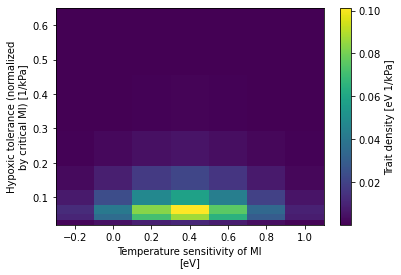

In [4]:
curator = util.curator_local_assets()
cat = curator.open_catalog()  
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_wgt

trait_spc_wgt.plot();

In [39]:
mi.dEodT_bar

0.022

## Use root finding technique to solve to ATmax

Loop over traits and values of $P_{\mathrm{O}_2}$ to find ATmax

First illustrate computation on a subset of traits.

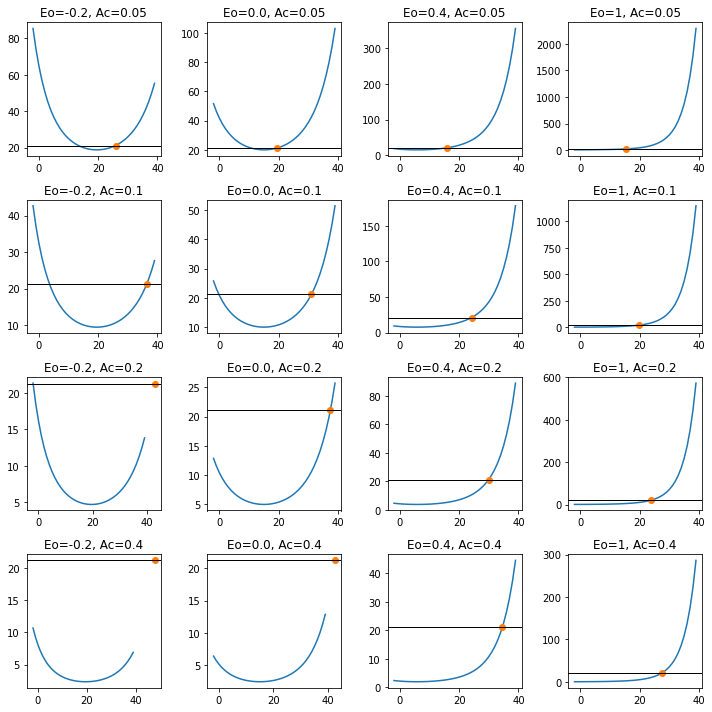

In [45]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

PO2_atm = constants.XiO2 * constants.kPa_per_atm

T = np.arange(-2., 40., 1.)

for i, Ac in enumerate([0.05, 0.1, 0.2, 0.4]):
    for j, Eo in enumerate([-0.2, 0., 0.4, 1]):
        ax = axs[i, j]
        ATmax_ij = mi.compute_ATmax(PO2_atm, Ac, Eo, dEodT=mi.dEodT_bar)
        ax.plot(T, mi.pO2_at_Phi_one(T, Ac, Eo, dEodT=mi.dEodT_bar), '-')
        ax.plot(ATmax_ij, PO2_atm, 'o')
        ax.axhline(PO2_atm, linewidth=1, color='k')
        ax.set_title(f'Eo={Eo}, Ac={Ac}')
        
fig.tight_layout()        

Now compute ATmax over entire trait-space domain.

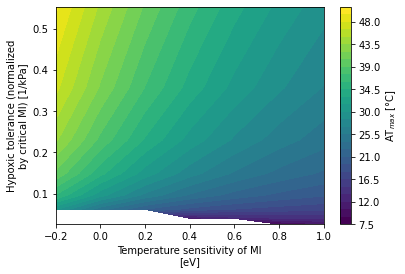

In [59]:
PO2_atm = constants.XiO2 * constants.kPa_per_atm

ATmax = xr.full_like(trait_spc_wgt, fill_value=0.)
ATmax.name = 'ATmax'
ATmax.attrs['long_name'] = 'AT$_{max}$'
ATmax.attrs['units'] = '°C'

T = np.arange(-2., 41., 1.)

for i, Ac in enumerate(trait_spc_wgt.Ac.values):
    for j, Eo in enumerate(trait_spc_wgt.Eo.values):
        ATmax_ij = mi.compute_ATmax(PO2_atm, Ac, Eo, dEodT=mi.dEodT_bar)
        ATmax[i, j] = ATmax_ij

ATmax.plot.contourf(levels=30);

## Save to local cache file

In [55]:
dso = ATmax.to_dataset()
dso

<xarray.Dataset>
Dimensions:  (Ac: 8, Eo: 7)
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Data variables:
    ATmax    (Ac, Eo) float64 nan nan nan nan nan ... 36.58 33.55 31.08 29.07

In [58]:
clobber = True

this_notebook = 'trait-space-ATmax.ipynb'

curator = util.curator_local_assets()

if clobber:
    cache_file = 'data/cache/idealized-trait-space-ATmax.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)   
    dso.to_zarr(cache_file, mode='w', consolidated=True); 
    
    curator.add_source(
        key='ATmax', 
        urlpath=cache_file,
        description=f'ATmax computed over idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )    
    
cat = curator.open_catalog()  
ds_cache = cat['ATmax'].to_dask()
xr.testing.assert_identical(dso, ds_cache)    

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
